Coefficients: [0.5 0.5]
Intercept: 0.5000000000000009
Predictions: [6. 7.]


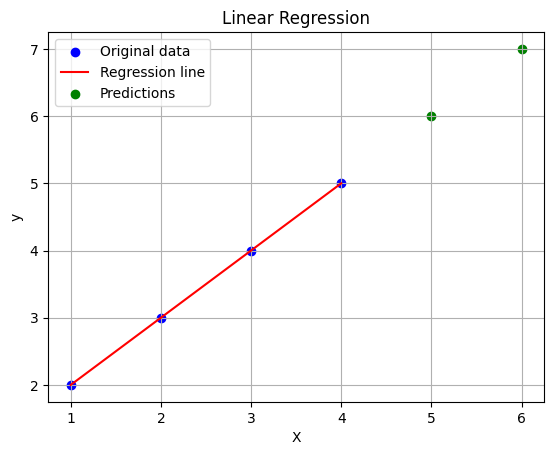

In [6]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib.axes as ax
from matplotlib.animation import FuncAnimation

# Sample data (replace with your own dataset)
X = np.array([[1, 2], [2, 3], [3, 4], [4, 5]])  # Independent variables
y = np.array([2, 3, 4, 5])                      # Dependent variable

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Print the coefficients
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

# Predict using the trained model
new_data = np.array([[5, 6], [6, 7]])  # New data for prediction
predictions = model.predict(new_data)
print("Predictions:", predictions)

# Plotting
plt.scatter(X[:,0], y, color='blue', label='Original data')  # Plot original data
plt.plot(X[:,0], model.predict(X), color='red', label='Regression line')  # Plot regression line
plt.scatter(new_data[:,0], predictions, color='green', label='Predictions')  # Plot predicted points
plt.xlabel('X')
plt.ylabel('y')
plt.title('Linear Regression')
plt.legend()
plt.grid(True)
plt.show()


In [7]:
from openfhe import *

In [16]:
# parameters = CCParamsBFVRNS()
# parameters.SetPlaintextModulus(65537)
# parameters.SetMultiplicativeDepth(2)

# crypto_context = GenCryptoContext(parameters)
# # Enable features that you wish to use
# crypto_context.Enable(PKESchemeFeature.PKE)
# crypto_context.Enable(PKESchemeFeature.key_pairWITCH)
# crypto_context.Enable(PKESchemeFeature.LEVELEDSHE)

# # Sample Program: Step 2: Key Generation

# # Generate a public/private key pair
# key_pair = crypto_context.KeyGen()

# # Generate the relinearization key
# crypto_context.EvalMultKeyGen(key_pair.secretKey)

# # Generate the rotation evaluation key_pair
# crypto_context.EvalRotateKeyGen(key_pair.secretKey, [1, 2, -1, -2])
X = np.array([1, 2, 2, 3, 3, 4, 4, 5])  # Independent variables
Y = np.array([2,2, 3,3, 4,4, 5,5])                      # Dependent variable
num_iterations = 1
mult_depth = 1
scale_mod_size = 50
# batch_size = 8
parameters = CCParamsCKKSRNS()
secret_key_dist = SecretKeyDist.UNIFORM_TERNARY
parameters.SetSecretKeyDist(secret_key_dist)
parameters.SetSecurityLevel(SecurityLevel.HEStd_NotSet)
parameters.SetRingDim(1 << 12)

if get_native_int()==128:
    rescale_tech = ScalingTechnique.FIXEDAUTO
    dcrt_bits = 78
    first_mod = 89
else:
    rescale_tech = ScalingTechnique.FLEXIBLEAUTO
    dcrt_bits = 59
    first_mod = 60

parameters.SetScalingModSize(dcrt_bits)
parameters.SetScalingTechnique(rescale_tech)
parameters.SetFirstModSize(first_mod)


level_budget = [1, 1]
bsgs_dim = [1,1]

levels_available_after_bootstrap = 10
depth = levels_available_after_bootstrap + FHECKKSRNS.GetBootstrapDepth(level_budget, secret_key_dist) + (num_iterations - 1)
parameters.SetMultiplicativeDepth(depth)

crypto_context = GenCryptoContext(parameters)
crypto_context.Enable(PKESchemeFeature.PKE)
crypto_context.Enable(PKESchemeFeature.KEYSWITCH)
crypto_context.Enable(PKESchemeFeature.LEVELEDSHE)
crypto_context.Enable(PKESchemeFeature.ADVANCEDSHE)
crypto_context.Enable(PKESchemeFeature.FHE)
ring_dim = crypto_context.GetRingDimension()
print(f"CKKS is using ring dimension {ring_dim}\n\n")

num_slots = 1
crypto_context.EvalBootstrapSetup(level_budget, bsgs_dim, num_slots)

print("The CKKS scheme is using ring dimension: " + str(crypto_context.GetRingDimension()))
key_pair = crypto_context.KeyGen()
crypto_context.EvalMultKeyGen(key_pair.secretKey)
crypto_context.EvalBootstrapKeyGen(key_pair.secretKey, num_slots)

# crypto_context.EvalRotateKeyGen(key_pair.secretKey, [1, -2])


CKKS is using ring dimension 4096


The CKKS scheme is using ring dimension: 4096


In [24]:
E_X = []
for x in X:
    plaintext1 = crypto_context.MakeCKKSPackedPlaintext([x])
    E_X.append(crypto_context.Encrypt(key_pair.publicKey, plaintext1))
E_Y = []
for y in Y:
    plaintext1 = crypto_context.MakeCKKSPackedPlaintext([y])
    E_Y.append(crypto_context.Encrypt(key_pair.publicKey, plaintext1))
print(f'E_X: {E_X}')
print(f'E_X: {E_Y}')


E_X: [<openfhe.Ciphertext object at 0x7fea3442d630>, <openfhe.Ciphertext object at 0x7fea3442df70>, <openfhe.Ciphertext object at 0x7fea3442daf0>, <openfhe.Ciphertext object at 0x7fea31acf130>, <openfhe.Ciphertext object at 0x7fea3442d670>, <openfhe.Ciphertext object at 0x7fea420f6f70>, <openfhe.Ciphertext object at 0x7feac7b54870>, <openfhe.Ciphertext object at 0x7fea31a56af0>]
E_X: [<openfhe.Ciphertext object at 0x7fea3442d5b0>, <openfhe.Ciphertext object at 0x7fea3442dd70>, <openfhe.Ciphertext object at 0x7fea3442ddf0>, <openfhe.Ciphertext object at 0x7fea3442da70>, <openfhe.Ciphertext object at 0x7fea3442d6f0>, <openfhe.Ciphertext object at 0x7fea3442d8b0>, <openfhe.Ciphertext object at 0x7fea3442da30>, <openfhe.Ciphertext object at 0x7fea3442dbb0>]


In [41]:
class HomomorphicLinearRegression:
    def __init__(self, crypto_context, key_pair):
        self.crypto_context = crypto_context
        self.key_pair = key_pair
        self.parameters = {}

    def encrypt_data(self, X, y):
        

        E_X = []
        for x in X:
            plaintext1 = crypto_context.MakeCKKSPackedPlaintext([x],1, depth -1,None,1)
            E_X.append(crypto_context.Encrypt(key_pair.publicKey, plaintext1))
        E_Y = []
        for y in Y:
            plaintext1 = crypto_context.MakeCKKSPackedPlaintext([y],1, depth -1,None,1)
            E_Y.append(crypto_context.Encrypt(key_pair.publicKey, plaintext1))
        return E_X, E_Y

    def forward_propagation(self, train_input):
        m = self.parameters['m']
        c= self.parameters['c']
        y_hats = []
        # level_budget = [1, 1]
        # bsgs_dim = [1,1]
        for x in range(len(train_input)):
            # self.crypto_context.EvalBootstrapSetup(level_budget, bsgs_dim, 1)
            # self.crypto_context.EvalBootstrapKeyGen(self.key_pair.secretKey, 1)
            ciphertext_after = self.crypto_context.EvalBootstrap(train_input[x])
            eval_mul = self.crypto_context.EvalMult(ciphertext_after,m)
            eval_sum = self.crypto_context.EvalAdd(eval_mul,c)
            
            y_hats.append(eval_sum)
        # for y_hat in y_hats:
        #     result = self.crypto_context.Decrypt(y_hat,self.key_pair.secretKey)
        #     result.SetLength(1)
        #     print("y_hat = " + str(result))


        return y_hats

    def cost_function(self, predictions, train_output):
        if len(predictions) != len(train_output):
            return
        eval_cost = 0
        for y_hat, output in zip(predictions, train_output):
            eval_sub = self.crypto_context.EvalSub(y_hat,output)
            ciphertext_after = self.crypto_context.EvalBootstrap(eval_sub)
            eval_square = self.crypto_context.EvalSquare(ciphertext_after)
            eval_cost = self.crypto_context.EvalAdd(eval_square,eval_cost)
        ciphertext_after = self.crypto_context.EvalBootstrap(eval_cost)
        eval_cost = self.crypto_context.EvalMult(eval_cost,1/len(predictions))
        # result = self.crypto_context.Decrypt(eval_cost,self.key_pair.secretKey)
        # result.SetLength(1)
        # print("eval_cost = " + str(result))
        return eval_cost

    def mean_homo(self, Z):

        eval_cost = 0
        for z in Z:
            eval_cost = self.crypto_context.EvalAdd(z,eval_cost)
        c = 1 / len(Z)
        # Adjust noiseScaleDeg and level as needed
        ciphertext_after = self.crypto_context.EvalBootstrap(eval_cost)
        eval_mean = self.crypto_context.EvalMult(ciphertext_after,c)
        return eval_mean

    def backward_propagation(self, train_input, train_output, predictions):
        derivates = {}
        two = 2  # Adjust noiseScaleDeg and level as needed
        # Calculate dm 
        dfs = []
        for pred, output in zip(predictions, train_output):
            df = self.crypto_context.EvalSub(pred,output)
            dfs.append(df)
        eval_muls = []
        for i, df in zip(train_input, dfs):
            ciphertext_after = self.crypto_context.EvalBootstrap(i)
            ciphertext_after2 = self.crypto_context.EvalBootstrap(df)
            eval_mul = self.crypto_context.EvalMult(ciphertext_after,ciphertext_after2)
            eval_muls.append(eval_mul)
        mean = self.mean_homo(eval_muls)
        ciphertext_after = self.crypto_context.EvalBootstrap(mean)
        dm = self.crypto_context.EvalMult(ciphertext_after,two)
        # Calcualte the dc
        mean = self.mean_homo(dfs)
        ciphertext_after = self.crypto_context.EvalBootstrap(mean)
        dc = self.crypto_context.EvalMult(ciphertext_after, two)

        # Assign values to dm and dc
        derivates["dm"] = dm
        derivates["dc"] = dc
        return derivates

    def update_parameters(self, derivates, learning_rate):
        self.parameters["m"] = self.crypto_context.EvalSub(
            self.parameters["m"],
            self.crypto_context.EvalMult(learning_rate, derivates["dm"]),
        )
        self.parameters["c"] = self.crypto_context.EvalSub(
            self.parameters["c"],
            self.crypto_context.EvalMult(learning_rate, derivates["dc"]),
        )

    ##########################

    def train(self, E_X, E_Y, num_iterations=100, learning_rate=0.01):
        # Assuming E_X is structured correctly as per previous discussions
        # num_samples = len(E_X)  # Number of samples
        num_features = 8  # Assuming this is the correct way to determine the number of features

        # Initialize coefficients (weights and intercept) as encrypted 0.0 values
        # initial_plaintext = self.crypto_context.MakeCKKSPackedPlaintext([0.0])  # Adjust noiseScaleDeg and level as needed
        # self.coefficients = [self.crypto_context.Encrypt(self.key_pair.publicKey, initial_plaintext) for _ in range(num_features + 1)]
        
        self.parameters["m"] = np.random.uniform(0, 1) * -1
        
        self.parameters["c"] = np.random.uniform(0, 1) * -1
        self.loss = []

        # Initialize figure and axis for animation
        # fig, ax = plt.subplots()
        # x_vals = np.linspace(min(E_X), max(E_X), 100)
        # line, = ax.plot(x_vals, self.parameters['m'] * x_vals +
        #                 self.parameters['c'], color='red', label='Regression Line')
        # ax.scatter(X, y, marker='o',
        #         color='green', label='Training Data')

        # # Set y-axis limits to exclude negative values
        # ax.set_ylim(0, max(y) + 1)

        def update(i):
            # Forward propagation
            predictions = self.forward_propagation(E_X)
            # print(f"predictions: {predictions}")
            # print(f'E_Y: {E_Y}')
            # # Cost function
            cost = self.cost_function(predictions, E_Y)

            # # Back propagation
            derivatives = self.backward_propagation(E_X, E_Y, predictions)

            # # Update parameters
            self.update_parameters(derivatives, learning_rate)

            # # Update the regression line
            # # line.set_ydata(self.parameters['m']
            # #             * x_vals + self.parameters['c'])

            # # Append loss and print
            # self.loss.append(cost)
            # print("Iteration = {}, Loss = {}".format(i + 1, cost))

            # return line,

        for i in range(1):
            update(i)

        m = self.crypto_context.Decrypt(self.parameters['m'],self.key_pair.secretKey)
        c = self.crypto_context.Decrypt(self.parameters['c'],self.key_pair.secretKey)
        # # Create animation
        # ani = FuncAnimation(fig, update, frames=num_iterations, interval=200, blit=True)
        # # Save the animation as a video file (e.g., MP4)
        # ani.save('linear_regression_A.gif', writer='ffmpeg')

        # plt.xlabel('Input')
        # plt.ylabel('Output')
        # plt.title('Linear Regression')
        # plt.legend()
        # plt.show()

        return m,c

    def decrypt_coefficients(self):
        if self.coefficients is None:
            print("Model coefficients are not trained yet.")
            return None
        else:
            return [
                self.crypto_context.Decrypt(self.key_pair.secretKey, coeff)
                for coeff in self.coefficients
            ]


In [42]:
# Initialize the class with cryptographic context and key pair
homo_lr = HomomorphicLinearRegression(crypto_context, key_pair)

# Encrypt the data
E_X, E_Y = homo_lr.encrypt_data(X, y)

# Train the model
m,c =homo_lr.train(E_X, E_Y)

# Decrypt the trained coefficients
# coefficients = homo_lr.decrypt_coefficients()
# print("Trained coefficients:", coefficients)

({'m': <openfhe.Ciphertext at 0x7fdd09605af0>,
  'c': <openfhe.Ciphertext at 0x7fdd096050b0>},
 [])